In [2]:
#libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter

In [3]:
# Set global theme settings for plotting
plt.rcParams.update({
    'font.size': 20,          # Set font size
    'lines.linewidth': 3,     # Set default line thickness
    'axes.titlesize': 20,     # Title font size
    'axes.labelsize': 18,     # Axis label font size
    'xtick.labelsize': 14,    # X-tick label font size
    'ytick.labelsize': 14,    # Y-tick label font size
    'grid.color': 'gray',     # Grid color
    'grid.linestyle': '--',   # Grid line style
    'grid.linewidth': 0.5,    # Grid line width
    'legend.fontsize': 16     # Legend font size
})

In [4]:
human_Ud = 2.0
PopulationSize = [100, 1000, 10000]
human_popsize = 10000
sd = -10**(-np.linspace(1, 2.5, 10))
iterations = 1000

Kimetalsd = -0.009
Boykoetalsd = -0.029


#x is the number of segregating mutations per individual
xmean = -human_Ud/sd
Kim_xmean = -human_Ud/Kimetalsd
Boyko_xmean = -human_Ud/Boykoetalsd


negative_Eepsilon = -np.linspace(0.000001, 0.01, 50)
positive_Eepsilon = np.linspace(0.000001, 0.01, 30)



In [23]:
def get_min_poisson_sample(xmean, samplesize):
  """
  Generates a sample of a Poisson distribution. and spits the minimum value for this sample
  """
  sample = np.random.poisson(lam=xmean, size=samplesize)
  return np.min(sample)

def get_mean_stderror_min_poisson_sample(xmean, samplesize, iterations):
  """
  Generates the expected minimum and standard error of iterations samples of Poisson distribution of size samplesize.
  """

  array_minx = []
  for i in range(iterations):
    result = get_min_poisson_sample(xmean, samplesize)
    array_minx.append(result)

  mean_array_minx = np.mean(array_minx)
  std_dev_array_minx = np.std(array_minx)
  std_error_array_minx = std_dev_array_minx / np.sqrt(iterations)
  return mean_array_minx, std_error_array_minx

vget_mean_stderror_min_poisson_sample = np.vectorize(get_mean_stderror_min_poisson_sample)

def get_growht_rate(segregating_mutations, E_selectioncoeff, E_epsilon, Ud):
  if E_epsilon != 0:
    exponential_term = np.exp(-Ud*E_epsilon/(E_selectioncoeff**2))
    genotype_term = (1.0+(E_epsilon/E_selectioncoeff))**(segregating_mutations)
    rbest = -(E_selectioncoeff**2)*(exponential_term-genotype_term)/(exponential_term*E_epsilon)
  else:
    rbest = E_selectioncoeff*segregating_mutations+Ud
  return rbest

def get_selective_deaths(xmin, E_selectioncoeff, E_epsilon, Ud):
  fitness_best = np.exp(get_growht_rate(xmin, E_selectioncoeff, E_epsilon, Ud))
  fraction_selective_deaths = 1-(1/fitness_best)
  return fraction_selective_deaths

vget_selective_deaths = np.vectorize(get_selective_deaths)


In [29]:
expected_min_Kim, std_error_Kim = get_mean_stderror_min_poisson_sample(Kim_xmean, human_popsize, iterations)
print(expected_min_Kim)
print(Kim_xmean)
print(get_growht_rate(expected_min_Kim, Kimetalsd, 0.005, human_Ud))
print(get_growht_rate(Kim_xmean, Kimetalsd, 0.005, human_Ud))

167.231
222.22222222222223
-0.016199914830708914
-0.0162


In [6]:
expected_min_N0, std_error_min_N0 = vget_mean_stderror_min_poisson_sample(xmean, PopulationSize[0], iterations)
expected_min_N1, std_error_min_N1 = vget_mean_stderror_min_poisson_sample(xmean, PopulationSize[1], iterations)
expected_min_N2, std_error_min_N2 = vget_mean_stderror_min_poisson_sample(xmean, PopulationSize[2], iterations)

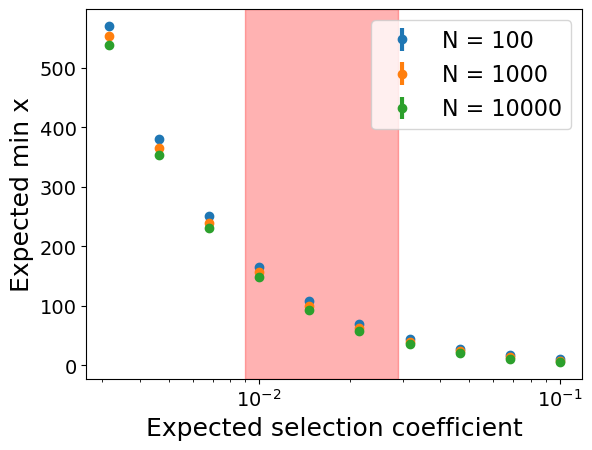

In [7]:
plt.errorbar(x=-sd, y=expected_min_N0, yerr=std_error_min_N0, fmt='o', label='N = ' + str(PopulationSize[0]))
plt.errorbar(x=-sd, y=expected_min_N1, yerr=std_error_min_N1, fmt='o', label='N = ' + str(PopulationSize[1]))
plt.errorbar(x=-sd, y=expected_min_N2, yerr=std_error_min_N2, fmt='o', label='N = ' + str(PopulationSize[2]))
plt.xscale('log')
plt.xlabel('Expected selection coefficient')
plt.ylabel('Expected min x')
plt.axvspan(-Kimetalsd, -Boykoetalsd, color='r', alpha=0.3)
plt.legend()
plt.savefig('graphs/Expectedminx.png', bbox_inches='tight') 

In [ ]:
expected_min_Kim, std_error_Kim = get_mean_stderror_min_poisson_sample(Kim_xmean, human_popsize, iterations)
mult_selective_deaths = get_selective_deaths(expected_min_Kim, Kimetalsd, 0, human_Ud)
negative_epistais_selective_deaths = vget_selective_deaths(expected_min_Kim, Kimetalsd, negative_Eepsilon, human_Ud)
positive_epistais_selective_deaths = vget_selective_deaths(expected_min_Kim, Kimetalsd, positive_Eepsilon, human_Ud)

/tmp/ipykernel_25580/3812018300.py:28: RuntimeWarning: invalid value encountered in scalar power
  genotype_term = (1.0+(E_epsilon/E_selectioncoeff))**(xmin)


/tmp/ipykernel_25580/509859472.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(x_formatter)


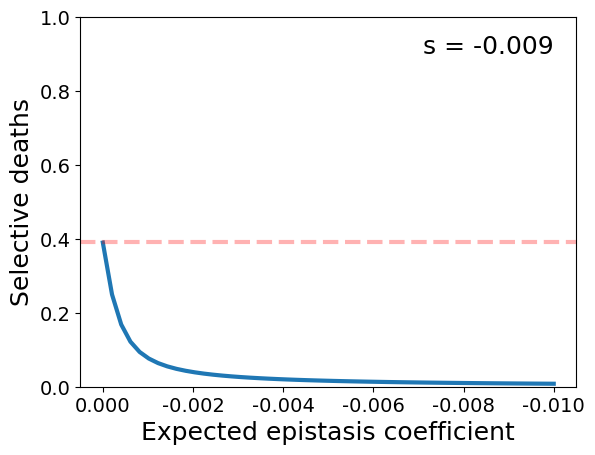

In [9]:
x_locator = FixedLocator([0.000, 0.002, 0.004, 0.006, 0.008, 0.010])
x_formatter = FixedFormatter(['0.000', '-0.002', '-0.004', '-0.006', '-0.008', '-0.010'])

fig = plt.figure()
ax = fig.gca()
ax.plot(-negative_Eepsilon, negative_epistais_selective_deaths)
#plt.xscale('log')
ax.set_xlabel('Expected epistasis coefficient')
ax.set_ylabel('Selective deaths')
ax.axhline(y=mult_selective_deaths, color='r', alpha=0.3, linestyle='--')
ax.set_ylim(0, 1)
ax.text(0.010, 0.9, "s = " + str(Kimetalsd), fontsize=18, ha='right')
ax.xaxis.set_major_formatter(x_formatter)
ax.xaxis.set_major_locator(x_locator)
fig.savefig('graphs/Selectivedeaths_Kimnegativeepistasis.png', bbox_inches='tight') 

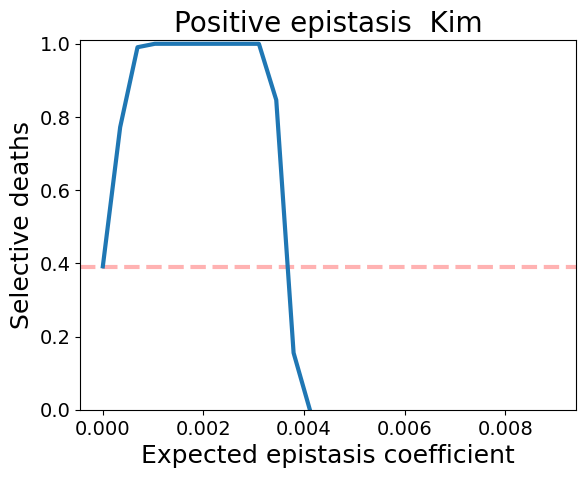

In [ ]:
plt.title("Positive epistasis  Kim")
plt.errorbar(x=positive_Eepsilon, y=positive_epistais_selective_deaths)
#plt.xscale('log')
plt.xlabel('Expected epistasis coefficient')
plt.ylabel('Selective deaths')
plt.ylim(0, 1.01)
plt.axhline(y=mult_selective_deaths, color='r', alpha=0.3, linestyle='--')
#plt.savefig('graphs/Expectedminx.png', bbox_inches='tight') 

In [ ]:
expected_min_Boyko, std_error_Boyko = get_mean_stderror_min_poisson_sample(Boyko_xmean, human_popsize, iterations)
mult_selective_deaths = get_selective_deaths(expected_min_Boyko, Boykoetalsd, 0, human_Ud)
negative_epistais_selective_deaths = vget_selective_deaths(expected_min_Boyko, Boykoetalsd, negative_Eepsilon, human_Ud)
positive_epistais_selective_deaths = vget_selective_deaths(expected_min_Boyko, Boykoetalsd, positive_Eepsilon, human_Ud)

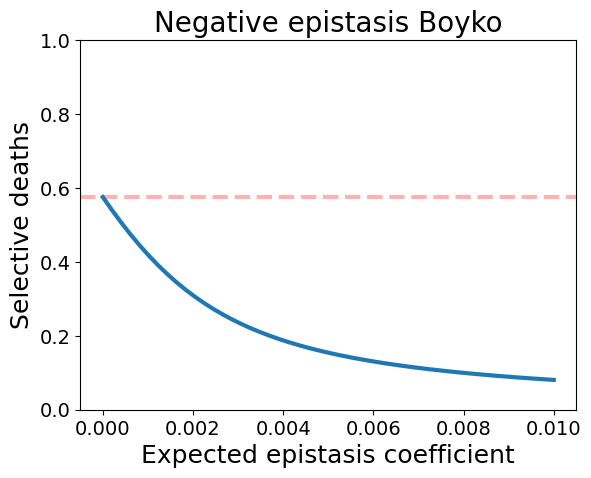

In [12]:
plt.title("Negative epistasis Boyko")
plt.errorbar(x=-negative_Eepsilon, y=negative_epistais_selective_deaths)
#plt.xscale('log')
plt.xlabel('Expected epistasis coefficient')
plt.ylabel('Selective deaths')
plt.axhline(y=mult_selective_deaths, color='r', alpha=0.3, linestyle='--')
plt.ylim(0, 1)
plt.savefig('graphs/Selectivedeaths_Boykonegativeepistasis.png', bbox_inches='tight') 

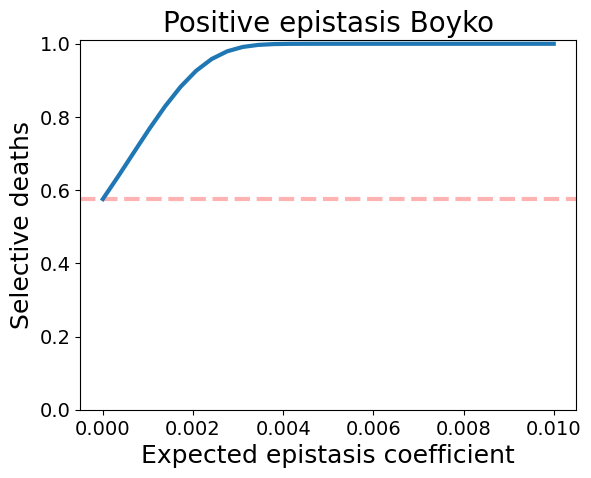

In [ ]:
plt.title("Positive epistasis Boyko")
plt.errorbar(x=positive_Eepsilon, y=positive_epistais_selective_deaths)
#plt.xscale('log')
plt.xlabel('Expected epistasis coefficient')
plt.ylabel('Selective deaths')
plt.ylim(0, 1.01)
plt.axhline(y=mult_selective_deaths, color='r', alpha=0.3, linestyle='--')
#plt.savefig('graphs/Expectedminx.png', bbox_inches='tight') 